<a href="https://colab.research.google.com/github/dht7166/colorFix/blob/master/colorFix_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras import layers
from keras import models
from keras.models import Model
import numpy as np
from keras import backend as K
from keras.activations import relu
from keras.layers import Input,Conv2D,LeakyReLU,BatchNormalization,MaxPool2D,Dense
from keras.layers import UpSampling2D,Add,Cropping2D,Concatenate,AveragePooling2D, ReLU
W,H,C = (512,512,1) # 1024 x 1024 x 1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [48]:
def l1_loss(yTrue,yPred):
  return K.mean(K.abs(yTrue-yPred)) 


# Setting up the model
inp = Input((W,H,C))
# The encoder
x = inp
for i in range(1,3):
  x = Conv2D(32*i,kernel_size=(3,3),padding='same',strides=(1,1),name=
                    'conv_'+str(i))(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPool2D(pool_size=(2,2))(x)

x = Dense(128,activation = 'sigmoid',name = 'encoder')(x)

# The decoder
layer = [64,32,C]
for i in range(3,5):
  x = UpSampling2D(size = (2,2),name = 'upsample_'+str(i))(x)
  x = Conv2D(layer[i-5],kernel_size  = (3,3),padding = 'same',strides = (1,1),
             name ='conv_'+str(i))(x)
  x = ReLU()(x)

x = Dense(C,activation = 'sigmoid',name = 'decoder')(x)

autoencoder = Model(inp,x,name = 'autoencoder')
optimizer = keras.optimizers.Adam(lr = 1e-3)
autoencoder.compile(optimizer=optimizer,loss = l1_loss)
autoencoder.summary()
autoencoder.load_weights('drive/My Drive/coloFix_autoencoder/autoencoder_grey.h5',by_name=True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 512, 512, 1)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 512, 512, 32)      320       
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (None, 512, 512, 32)      0         
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 256, 256, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 256, 256, 64)      18496     
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 128, 128, 64)      

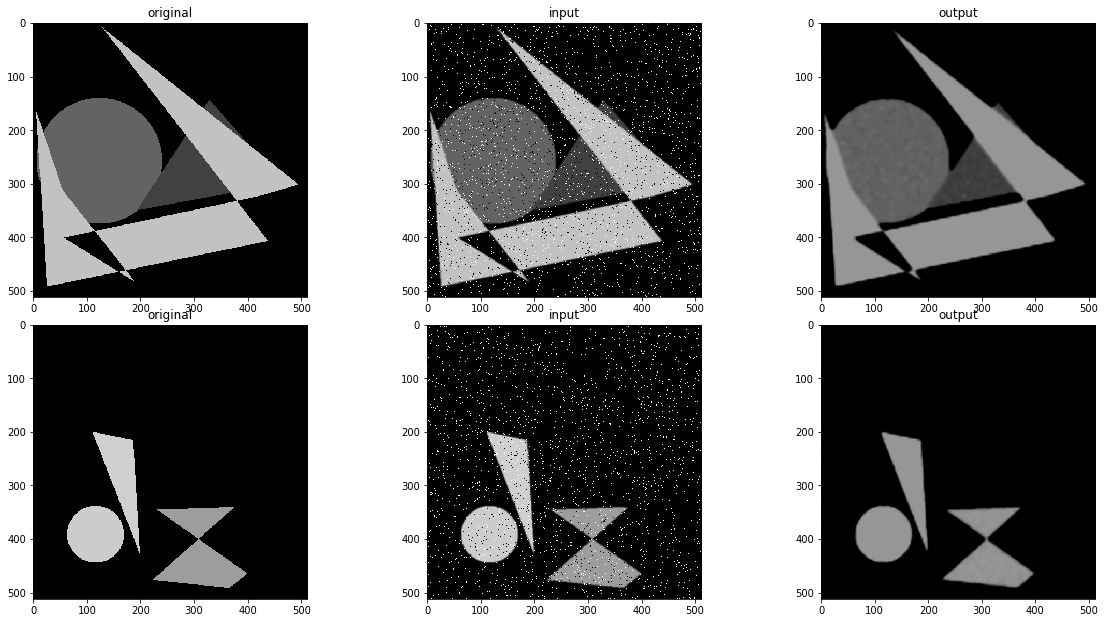

In [49]:
# Create the generator

from keras.utils import Sequence
import numpy as np
import random
from matplotlib import pyplot as plt
from skimage import io,transform
from skimage.draw import  polygon, circle
from skimage.util import random_noise


# Helper function to generate images
def draw_image(show = False):
  # Draw random shapes onto a blank 1024 x 1024 canvas, grey scale
  image = np.zeros((W,H))
  # Draw circle
  num_circle = random.randint(1,3)
  for i in range(num_circle):
    rr,cc = circle(random.randint(0,W),random.randint(0,H),random.randint(0,int(W/3+H/3)),image.shape)
    image[rr,cc] = random.uniform(0.2,1)
  # Draw polygon
  num_poly = random.randint(1,3)
  for i in range(num_poly):
    edge = random.randint(3,10)
    rr = [random.randint(0,W) for i in range(edge)]
    cc = [random.randint(0,H) for i in range(edge)]
    rr,cc = polygon(rr,cc)
    image[rr,cc] = random.uniform(0.2,1)
  if show:
    plt.imshow(image,cmap='gray', vmin=0, vmax=1)
    plt.show()
  return image

# Helper function to distort images
def distort(image,show = False):
  # blur
  image = transform.resize(image,(256,256))
  image = transform.resize(image,(W,H))
  # Add random noise
  image = random_noise(image,mode = 's&p')
  if show:
    plt.imshow(image,cmap='gray', vmin=0, vmax=1)
    plt.show()
  return image


# The generator class

# Create the generator
# Our generator only takes images size 1024 x 1024 and up, since we want to make
# sure all images are of high quality

class TrainData(Sequence):
  def __init__(self,batch = 5,model = None):
    self.batch = batch
    self.model = model


  def on_epoch_end(self):
    # Plot some image
    fig = plt.figure(figsize = (20,20))
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.1)
    for row in range(2): # 2 images per epoch
      image = draw_image()
      draw_slot = fig.add_subplot(2,3,row*3+1)
      draw_slot.set_title('original')
      plt.imshow(image,cmap='gray', vmin=0, vmax=1)

      image = distort(image)
      draw_slot = fig.add_subplot(2,3,row*3+2)
      draw_slot.set_title('input')
      plt.imshow(image,cmap='gray', vmin=0, vmax=1)

      image = image[:,:,np.newaxis]
      image = image[np.newaxis,:]
      #print(image.shape)
      image = self.model.predict(image)
      draw_slot = fig.add_subplot(2,3,row*3+3)
      draw_slot.set_title('output')
      plt.imshow(image[0,:,:,0],cmap='gray', vmin=0, vmax=1)

    plt.show()

  
  def __len__(self):
    return 100
  
  def __getitem__(self,idx):
    x = np.zeros((self.batch,W,H,C))
    y = np.zeros((self.batch,W,H,C))
    for i in range(self.batch):
      image = draw_image()
      y[i,:,:,0] = image
      image = distort(image)
      x[i,:,:,0] = image
    return x,y
  
TrainGen = TrainData(batch = 2,model = autoencoder)
TrainGen.on_epoch_end()

In [0]:
# Actually training

autoencoder.fit_generator(TrainGen,epochs = 5)

In [0]:
autoencoder.save('drive/My Drive/coloFix_autoencoder/autoencoder_grey.h5')

## TEMP CODE THAT WE DONT USE FOR NOW

